Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$

## Aluno:  Luiz Eduardo Hupalo 17203887

# Exercício 4: Regressão Logística

Neste exercício você irá aplicar um classificador de regressão logística em diversos conjuntos de dados. 
Além disso, você irá explorar a adição de atributos polinomiais e a utilização de regularização, bem como outras formas de avaliação de classificadores binários. Finalmente, você irá investigar técnicas de classificação multi-classe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1]):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    X = np.zeros((n_samples,1))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        k = i % n_classes
        X[i,0] = (k*(1-overlap) + np.random.rand())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1]-x_scale[0])*X
    return X, y

def plot_data(X, y, colors=['bo','rx','gs','md','c^','yP']):
    ''' Plot 1-D or 2-D classification dataset '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = np.unique(y)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0],np.zeros(np.sum(y==classes[i])),colors[i])
        plt.gca().axes.get_yaxis().set_ticks([])
    else:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0],X[y==classes[i],1],colors[i])
    return

def plot_boundary(model, X, colors=['b','r','g','m','c','y'], N=400, gap=1e-9):
    ''' Plot boundary for a 1-D or 2-D classifier '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    dim = X.shape[1]
    assert 0 < dim <= 2
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,N), np.linspace(x2_min,x2_max,N2))
    if dim == 1:
        X = np.c_[xx1.reshape(-1)]
    else:
        X = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    y_pred = model.predict(X)
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    y_pred = enc.fit_transform(y_pred)
    assert len(enc.classes_) <= len(colors)
    levels = np.arange(len(enc.classes_)+1)-0.5
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1,xx2,y_pred,levels,colors=colors,alpha=0.25)
    plt.contour(xx1,xx2,y_pred,levels,colors='k',linewidths=1)
    return

# Conjunto de dados #1

O primeiro conjunto de dados que usaremos pode ser gerado e visualizado pelos comandos abaixo.

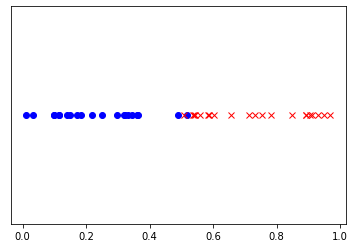

In [2]:
np.random.seed(2019*2)
X,y = gen_data(n_samples=42, n_classes=2, overlap=0.1)
plot_data(X,y)

## Classificação linear

- Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador. 
- Reporte a acurácia (= # de acertos / tamanho do conjunto) do classificador.
- Determine o valor do limiar de decisão a partir dos parâmetros do modelo.

#### Dicas

- Funções úteis:

```python
sklearn.linear_model.LogisticRegression() # utilize penalty='none' e solver='lbfgs'
plot_data(), plot_boundary() # fornecidas, utilize os parâmetros default
LogisticRegression.score(), .coef_, .intercept_
```

Number of iterations: 19
Training accuracy: 95.23809523809523 %
Decision threshold: 0.512475530598012


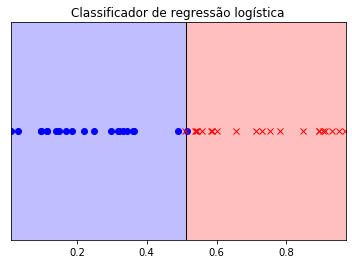

In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs')

log_reg.fit(X,y)

y_pred = log_reg.predict(X)


plot_boundary(log_reg, X)
plt.title('Classificador de regressão logística')
plot_data(X,y)

w = log_reg.coef_
b = log_reg.intercept_

# wx + b = 0
# x = -b/w
x = -b/w

score = log_reg.score(X,y)
nit = log_reg.n_iter_[0]

print("Number of iterations:",nit)
print("Training accuracy:",score*100,"%")
print("Decision threshold:",x[0][0])

- Trace o gráfico da predição do modelo de regressão (i.e., da variável contínua $\tilde{y} = \sigma(\bw^T\bx$)) sobre o conjunto de treinamento. Faça isso de três formas diferentes e confirme que todas fornecem o mesmo resultado:
 1. Usando a função `.predict_proba()` do modelo
 2. Escrevendo sua própria implementação a partir da função `.decision_function()`, a qual retorna o score de confiança $z = \bw^T\bx$
 3. Escrevendo sua própria implementação a partir dos parâmetros `.coef_` e `.intercept_`

Forma 1:

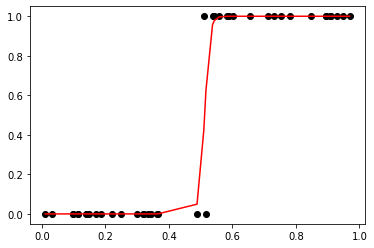

In [4]:
X_sorted = np.sort(X,axis=0)
p = log_reg.predict_proba(X_sorted)[:,1]

plt.plot(X,y,'ok')
plt.plot(X_sorted,p,'r')

Forma 2:

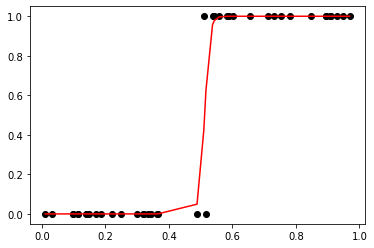

In [5]:
z = log_reg.decision_function(X_sorted)

sgm = 1/(1 + np.exp(-z))

plt.plot(X,y,'ok')
plt.plot(X_sorted,p,'r')

Forma 3:

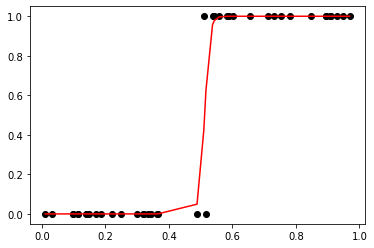

In [6]:
w = log_reg.coef_
b = log_reg.intercept_

y_hat = b + w*X_sorted
y_tilde = 1/(1 + np.exp(-y_hat))

plt.plot(X,y,'ok')
plt.plot(X_sorted,y_tilde,'r')

- Varie o grau de sobreposição no gerador do conjunto de dados (parâmetro `overlap`) e repita o gráfico da predição do item anterior. Para facilitar, copie e cole todos os comandos e os organize em um `for`. Utilize o mesmo `seed` do gerador de números aleatórios em todos os casos, para eliminar a variabilidade e assim enfatizar a influência do grau de sobreposição.
- Comente sobre os resultados observados.

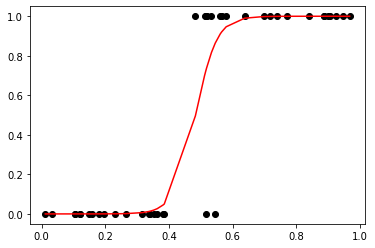

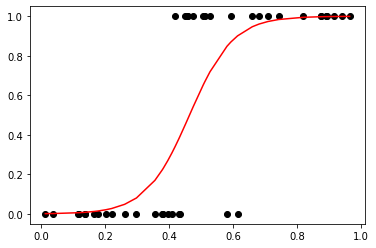

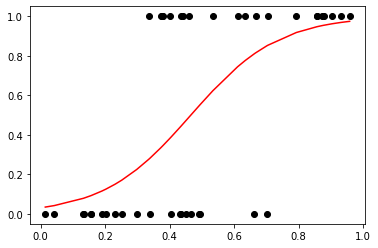

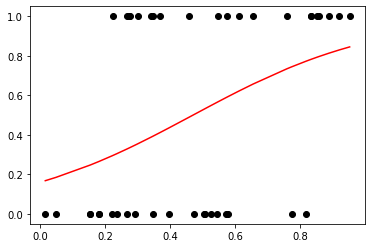

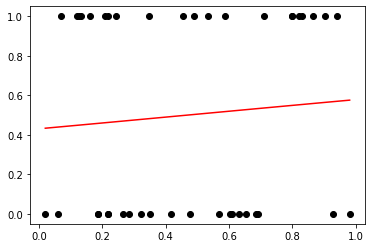

In [7]:
overlap = [0.2,0.4,0.6,0.8,1] 

for i in range(len(overlap)):
    
    np.random.seed(2019*2)
    X,y = gen_data(n_samples = 42, n_classes = 2,overlap = overlap[i])
    
    log_reg.fit(X,y)
    X_sorted = np.sort(X,axis=0)
    p = log_reg.predict_proba(X_sorted)[:,1]
    
    plt.figure(i)
    plt.plot(X,y,'ok')
    plt.plot(X_sorted,p,'r')

Quanto maior a sobreposição mais difícil o problema de classificação ficará.

# Conjunto de dados #2

O segundo conjunto de dados pode ser gerado pelos comandos abaixo.

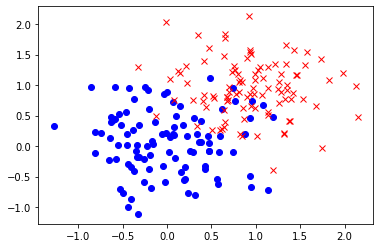

In [8]:
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=200, n_features=2, centers=[[0,0],[1,1]], cluster_std=0.5, random_state=0)
plot_data(X,y)

## Classificação linear

- Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador.
- Reporte o número de iterações realizadas pelo otimizador, a acurácia do classificador e o vetor de parâmetros $\bw$ (incluindo o termo de *bias* $w_0 = b$).
- Adicione regularização $\ell_2$ e vá aumentando gradativamente o grau de regularização ($\lambda$) e observando seu impacto no vetor $\bw$. Note que o sklearn utiliza como parâmetro de regularização exatamente o inverso, $C = 1/\lambda$.
- Adicionar regularização se mostrou útil? Por quê?

Modelo sem regularização:

Number of iterations: 11
Training accuracy: 91.0 %
w: [-3.67594993  3.66197729  3.74117257]


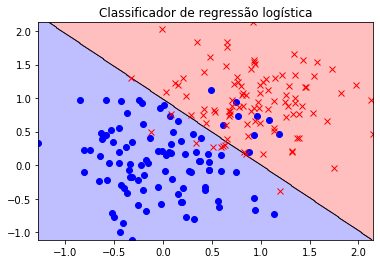

In [9]:
log_reg2 = LogisticRegression(penalty = 'none', solver = 'lbfgs')

log_reg2.fit(X,y)

y_pred2 = log_reg2.predict(X)


plot_boundary(log_reg2, X)
plt.title('Classificador de regressão logística')
plot_data(X,y)

w = log_reg2.coef_
b = log_reg2.intercept_

wm = np.c_[b,w]

score = log_reg2.score(X,y)
nit = log_reg2.n_iter_[0]

print("Number of iterations:",nit)
print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Modelo com regularização Ridge:

Number of iterations: 7
Training accuracy: 91.0 %
w: [-0.00435674  0.00463079  0.00434748]


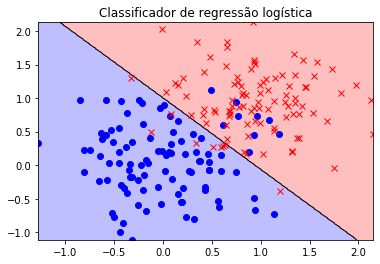

In [10]:
log_reg2 = LogisticRegression(C = 0.0001, solver = 'lbfgs')

log_reg2.fit(X,y)

y_pred2 = log_reg2.predict(X)


plot_boundary(log_reg2, X)
plt.title('Classificador de regressão logística')
plot_data(X,y)

w = log_reg2.coef_
b = log_reg2.intercept_

wm = np.c_[b,w]

score = log_reg2.score(X,y)
nit = log_reg2.n_iter_[0]

print("Number of iterations:",nit)
print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Conforme aumentamos o valor de $\lambda$, os elementos de $w$ diminuem. Aparentemente, utilizar regularização não melhorou em nada o score do modelo.

## Implementação em Python

Escreva uma implementação própria do classificador, completando a classe abaixo. Esta implementação é parcialmente compatível com o sklearn; em particular, as classes herdadas permitem automaticamente a utilização da função `.score()`. Para realizar o treinamento utilizaremos o otimizador do SciPy com o método BFGS (padrão do SciPy para problemas sem restrições), um método quase-Newton que requer apenas o cálculo do gradiente.

- Complete as funções `decision_function`, `predict_proba` (que você já implementou acima) e `predict`.
- Complete a função objetivo da otimização `__fobj`. Esta função deve retornar o valor da função custo e do gradiente no ponto atual ($\bw$).
- Repita os itens da seção anterior com o seu classificador e compare com a versão do sklearn. Confirme que o valor da acurácia é idêntico e os valores de $\bw$ são muito próximos (até pelo menos o terceiro dígito significativo).

Após essa parte, você pode ignorar a sua implementação e passar a usar a implementação do sklearn.

#### Dicas
- Ao invés de implementar a função logística, utilize a implementação do SciPy (possivelmente renomeando para um nome mais conveniente):
```python
from scipy.special import expit as sigmoid
```
- Adicione um valor pequeno e positivo (ex: `eps = 1e-200`) dentro do argumento do `np.log()` para evitar erros quando o argumento é igual a zero.

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit as sigmoid

class Model(BaseEstimator, ClassifierMixin):
    ''' Logistic regression with L2 regularization '''
    def __init__(self, lamb=0):
        self.lamb = lamb
        return
    
    def __add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new

    def __fobj(self, w, X, y):
        # Compute cost and gradient for optimization
        eps = 1e-200
        
        y_til = sigmoid(X @ w)
        m = X.shape[0]
        
        J = (1/m)*(-y.T @ np.log(y_til + eps) - ((1-y).T @ np.log((1-y_til) + eps)))
        
        grad = (1/m)*(X.T @ (y_til-y))
        
        return J, grad
    
    def fit(self, X, y):
        # Fit using BFGS solver (SciPy's default)
        from scipy.optimize import minimize
        X = self.__add_ones(X)
        res = minimize(fun=self.__fobj, x0=np.zeros(X.shape[1]), jac=True, args=(X,y))
        self.w = res.x
        self.n_iter_ = np.array([res.nit])
        self.J = self.__fobj(self.w,X,y)[0]
        return self
    
    def decision_function(self, X):
        X = self.__add_ones(X)
        z = X @ self.w
        return z
    
    def predict_proba(self, X):
        y_tilde = self.decision_function(X) > 0.5
        return y_tilde

    def predict(self, X):
        y_pred = (self.decision_function(X) > 0).astype(int)
        return y_pred
    
    def accuracy(self, X, y):
        ''' Return the mean accuracy '''
        y_pred = self.predict(X)
        correct = []
        for i in range(len(y)): 
            if (y_pred == y): 
                correct[i] = 1
        acc = np.sum(correct)/len(y)
        return acc

# Conjunto de dados #3

O próximo conjunto de dados é gerado pelos comandos abaixo. Note que agora temos também conjuntos de validação e de teste (extremamente grandes para fins didáticos).

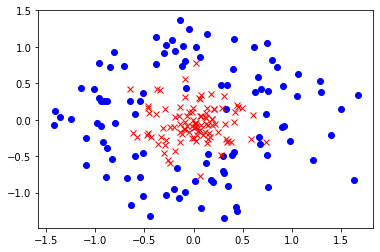

In [12]:
from sklearn.datasets import make_circles
np.random.seed(4)
X, y = make_circles(n_samples=200, noise=0.28, factor=0)
X_val, y_val = make_circles(n_samples=10000, noise=0.28, factor=0)
X_test, y_test = make_circles(n_samples=10000, noise=0.28, factor=0)
plot_data(X,y)

## Adicionando atributos

- Assim como antes, treine o classificador sem regularização, trace o gráfico das regiões de decisão e reporte o número de iterações.
- Reporte a acurácia no conjunto de treinamento e no conjunto de validação.
- Aprimore o modelo adicionando atributos polinomiais, até obter 100% de acurácia no conjunto de treinamento.
- Comente sobre o que você observou, tanto do ponto de vista quantitativo (acurácia) quanto qualitativo (formato regiões de decisão).
- Em seguida, para o grau encontrado acima, introduza regularização $\ell_2$ e vá aumentando gradualmente (desde $\lambda = 10^{-9}$) e verifique o comportamento do modelo. Novamente, comente sobre o que você observou.
- Qual lhe parece a escolha mais interessante de modelo? Por quê?
- Para o modelo escolhido, meça a acurácia no conjunto de teste e compare-a com a de validação.

#### Dicas
- Lembre que não há necessidade de incluir o termo constante (*bias*) nos atributos polinomiais adicionados.
- Caso tenha dificuldades de convergência, você pode experimentar, por exemplo:
 - aumentar o número máximo de iterações do otimizador (parâmetro `max_iter`);
 - utilizar um escalonador de atributos. Experimente aplicá-lo em diferentes posições no *pipeline* até obter os melhores resultados. (No meu caso a melhor escolha foi no início.)
- Para acessar o último modelo (o estimador) dentro de um *pipeline*, utilize `model.steps[-1][1]`

Classificador linear:

Number of iterations: 5
Training accuracy: 58.5 %
Validation accuracy: 49.2 %
w: [-0.00376399  0.04369643 -0.23330441]


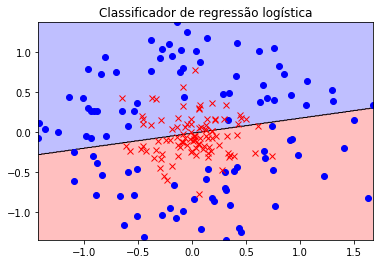

In [13]:
log_reg3 = LogisticRegression(penalty = 'none', solver = 'lbfgs')

log_reg3.fit(X,y)

y_pred3 = log_reg3.predict(X)


plot_boundary(log_reg3, X)
plt.title('Classificador de regressão logística')
plot_data(X,y)

w = log_reg3.coef_
b = log_reg3.intercept_

wm = np.c_[b,w]

score = log_reg3.score(X,y)
score_val = log_reg3.score(X_val,y_val)
nit = log_reg3.n_iter_[0]

print("Number of iterations:",nit)
print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")
print("w:", wm[0])

Adicionando atributos:

Training accuracy: 91.5 %
Validation accuracy: 92.32000000000001 %


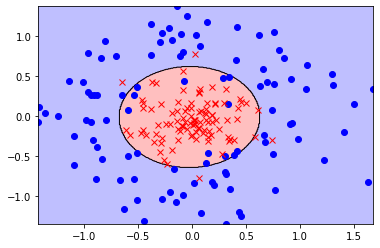

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Training accuracy: 94.0 %
Validation accuracy: 91.73 %


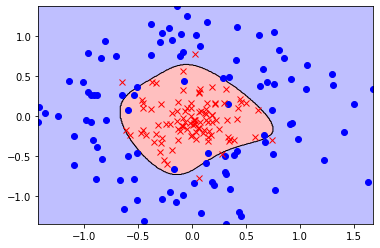

In [15]:
poly = PolynomialFeatures(degree = 4, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Training accuracy: 96.5 %
Validation accuracy: 89.14999999999999 %


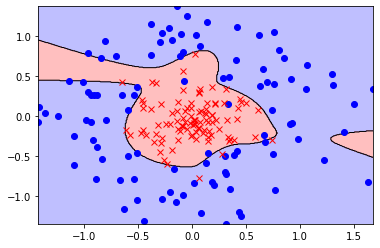

In [16]:
poly = PolynomialFeatures(degree = 6, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Training accuracy: 98.0 %
Validation accuracy: 88.53999999999999 %


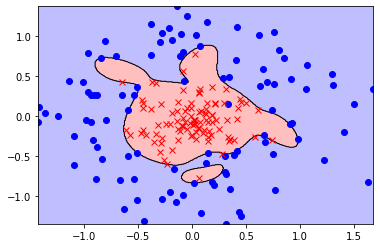

In [17]:
poly = PolynomialFeatures(degree = 10, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Training accuracy: 100.0 %
Validation accuracy: 85.9 %


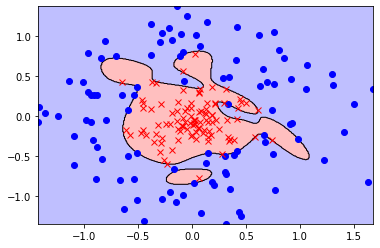

In [18]:
poly = PolynomialFeatures(degree = 14, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Conforme aumentamos os atributos, aumenta também a característica do overfitting. Para $d = 14$, a acurácia no conjunto de treinamento é $100\%$.

Training accuracy: 92.5 %
Validation accuracy: 92.13 %


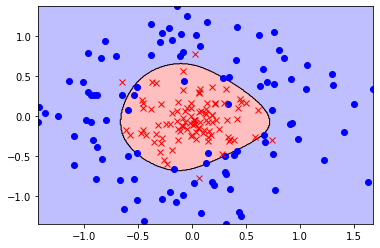

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(degree = 14, include_bias = False)

lr_pipeline = Pipeline([('scl1', StandardScaler()),('poly', poly),('scl2', StandardScaler()),('clf', LogisticRegression(C = 10, solver = 'lbfgs'))])

lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Training accuracy: 74.0 %
Validation accuracy: 75.38 %


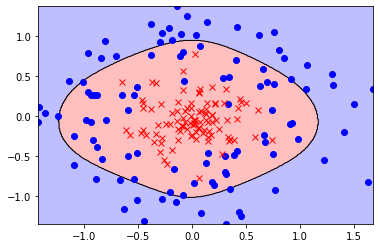

In [20]:
poly = PolynomialFeatures(degree = 14, include_bias = False)

lr_pipeline = Pipeline([('scl1', StandardScaler()),('poly', poly),('scl2', StandardScaler()),('clf', LogisticRegression(C = 0.0001, solver = 'lbfgs'))])

lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

# Conjunto de dados #4

O próximo conjunto de dados é gerado pelos comandos abaixo.

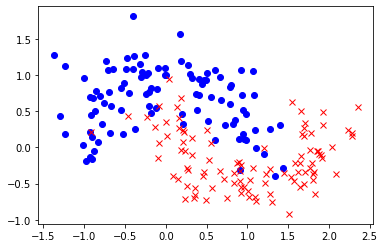

In [21]:
from sklearn.datasets import make_moons

np.random.seed(2019*2)
X, y = make_moons(n_samples=200, noise=0.25)
X_val, y_val = make_moons(n_samples=10000, noise=0.25)
X_test, y_test = make_moons(n_samples=10000, noise=0.25)
plot_data(X,y)

## Desenvolvimento do modelo

- Desenvolva um bom classificador de regressão logística, da forma que achar mais adequada.
- Justifique a sua escolha. Em particular, você consegue justificar que o modelo não está sofrendo nem de underfitting nem de overfitting?

Os dados parecem ser divididos por uma região que segue uma forma cúbica.

Training accuracy: 92.0 %
Validation accuracy: 92.96 %


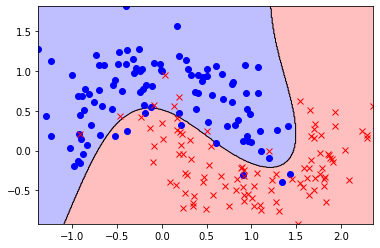

In [22]:
poly = PolynomialFeatures(degree = 3, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

Para $d>3$ começa a dar overfitting.

Training accuracy: 93.0 %
Validation accuracy: 89.52 %


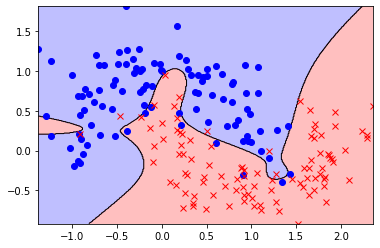

In [23]:
poly = PolynomialFeatures(degree = 5, include_bias = False)

lr_pipeline = make_pipeline(poly,Model())
lr_pipeline.fit(X,y)

score = lr_pipeline.score(X,y)
score_val = lr_pipeline.score(X_val,y_val)

print("Training accuracy:",score*100,"%")
print("Validation accuracy:",score_val*100,"%")

plot_data(X,y)
plot_boundary(lr_pipeline,X)

## Avaliação do modelo

Todos os itens abaixo se referem ao modelo escolhido no item anterior, o qual não deve ser mais alterado.

- Para o modelo escolhido, meça a acurácia de teste. 
- Calcule a matriz de confusão sobre o conjunto de validação.
- Calcule a taxa de falso positivo e a taxa de verdadeiro positivo.
- Trace o gráfico da curva ROC.
- Determine o valor do limiar de decisão para que a taxa de falso negativo seja inferior a 5%, bem como a taxa de falso positivo correspondente.
- (OPCIONAL) Compare a abordagem acima com a seguinte abordagem: treine novamente o modelo, variando os pesos do parâmetro `class_weight`, até conseguir a taxa de falso negativo desejada. Quais lhe parecem ser as vantagens e desvantagens dessa abordagem?

#### Dicas
- Funções úteis:
```python
from sklearn.metrics import confusion_matrix, roc_curve
np.nonzero()
```

# Conjunto de dados #5

O próximo [conjunto de dados](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) é real: foi introduzido R. A. Fisher em 1936 e tornou-se um clássico da área, sendo muito utilizado até hoje por quem está iniciando. Consiste de 4 atributos medidos de 150 amostras de 3 espécies de flores do gênero íris.

O objetivo é distinguir entre as 3 espécies, i.e., trata-se de um problema de classificação multi-classe. O conjunto de dados é pequeno e o objetivo do exercício é apenas ilustrar a classificação multi-classe; assim, utilize todo o conjunto de dados como conjunto de treinamento.

O conjunto de dados pode ser carregado pelos comandos abaixo.

In [24]:
from sklearn.datasets import load_iris
data = load_iris()
print(data['feature_names'])
print(data['target_names'])
X = data['data']
y = data['target']
print(X.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4) (150,)


## Classificação multi-classe: regressão logística one-vs-rest

- Treine um classificador linear (i.e., com os atributos originais) por regressão logística sem regularização, e reporte a acurácia e a matriz de confusão. Inicialmente, utilize a opção `multi_class='ovr'` (one-vs-rest).
- Escolha dois atributos e considere um conjunto de dados simplificado contendo apenas esses dois atributos (para permitir a visualização). Treine, calcule a acurácia e trace as regiões de decisão. Qual par de atributos permitiu a maior acurácia?

Utilizando como parâmetros "sepal length (cm)" e "sepal width (cm)":

Training accuracy: 80.66666666666666 %
w: [ 276.67727716 -134.80324427  147.37951668]


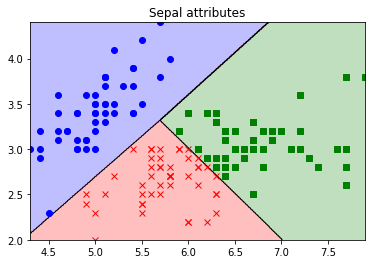

In [25]:
log_reg5 = LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class= 'ovr')


log_reg5.fit(X[:,0:2],y)

y_pred5 = log_reg5.predict(X[:,0:2])


plot_boundary(log_reg5, X[:,0:2])
plt.title('Sepal attributes')
plot_data(X[:,0:2],y_pred5)

w = log_reg5.coef_
b = log_reg5.intercept_

wm = np.c_[b,w]

score = log_reg5.score(X[:,0:2],y)

print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Utilizando como parâmetros 'petal length (cm)', 'petal width (cm)':

Training accuracy: 96.0 %
w: [ 41.42457221 -11.46429691 -16.37221147]


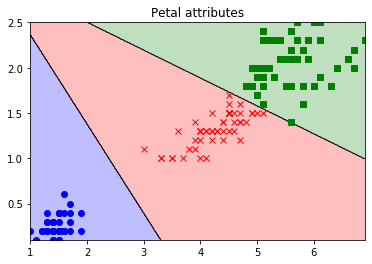

In [26]:
log_reg5 = LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class= 'ovr')


log_reg5.fit(X[:,2:5],y)

y_pred5 = log_reg5.predict(X[:,2:5])


plot_boundary(log_reg5, X[:,2:5])
plt.title('Petal attributes')
plot_data(X[:,2:5],y_pred5)

w = log_reg5.coef_
b = log_reg5.intercept_

wm = np.c_[b,w]

score = log_reg5.score(X[:,2:5],y)

print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Utilizando os atributos da pétala a classifição foi mais certeira.

## Classificação multi-classe: regressão softmax

- Agora, substitua pela opção `multi_class='multinomial'` e repita os itens da seção anterior. Você percebeu alguma diferença?

Training accuracy: 83.33333333333334 %
w: [237.78339787 -88.16037802  73.92187088]


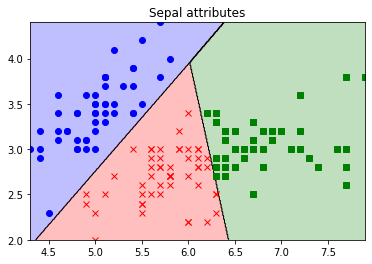

In [27]:
log_reg5 = LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class= 'multinomial')


log_reg5.fit(X[:,0:2],y)

y_pred5 = log_reg5.predict(X[:,0:2])


plot_boundary(log_reg5, X[:,0:2])
plt.title('Sepal attributes')
plot_data(X[:,0:2],y_pred5)

w = log_reg5.coef_
b = log_reg5.intercept_

wm = np.c_[b,w]

score = log_reg5.score(X[:,0:2],y)

print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Training accuracy: 96.0 %
w: [ 41.12285302  -8.35272804 -17.97102473]


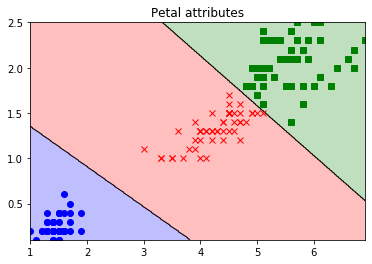

In [28]:
log_reg5 = LogisticRegression(penalty = 'none', solver = 'lbfgs', multi_class= 'multinomial')


log_reg5.fit(X[:,2:5],y)

y_pred5 = log_reg5.predict(X[:,2:5])


plot_boundary(log_reg5, X[:,2:5])
plt.title('Petal attributes')
plot_data(X[:,2:5],y_pred5)

w = log_reg5.coef_
b = log_reg5.intercept_

wm = np.c_[b,w]

score = log_reg5.score(X[:,2:5],y)

print("Training accuracy:",score*100,"%")
print("w:", wm[0])

Houve melhora para o caso do uso dos atributos "sepal".